In [1]:

import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils import data
def prepare_data():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

    root_dir = "./data3/train";
    train_set = datasets.ImageFolder(root = root_dir,
                transform = transforms.ToTensor())

    trainloader = data.DataLoader(train_set, batch_size = 4, shuffle = True)

    root_dir = "./data3/test";

    train_set = datasets.ImageFolder(root = root_dir,
                transform = transforms.ToTensor())

    testloader = data.DataLoader(train_set, batch_size =4, shuffle = True)
    classes = ('Natalie Portman', 'Julia Roberts', 'Neil Patrick Harris'
                    , 'Keifer Sutherland', 'Ben Stiller', 'Anne Hathaway'
                    , 'David Boreanaz', 'Jamie Foxx', 'Sofia Vergara'
                    , 'Elizabeth Banks', 'Jensen Ackles', 'Amy Adams'
                    , 'Kristen Bell', 'Bradley Cooper', 'Emily Deschanel'
                    , 'Zooey Deschanel', 'Jon Hamm', 'Scarlett Johansson'
                    , 'Blake Lively', 'Eva Longoria', 'Amy Poehler'
                    , 'Kristen Stewart', 'Kerry Washington', 'Leighton Meester'
                    , 'Olivia Wilde', 'Zac Efron', 'Miley Cyrus','Jim Parsons')
    return trainloader, testloader, classes
trainloader, testloader, classes = prepare_data()
#
print("train size: " + str(len(trainloader)))
#
print("test size: " + str(len(testloader)))

train size: 2800
test size: 693


cpu
Natalie Portman


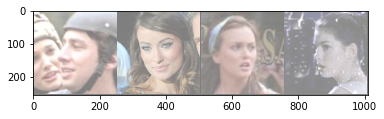

In [8]:
trainloader, testloader, classes = prepare_data()

import matplotlib.pyplot as plt
import numpy as np



# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.device)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(1)))

In [20]:
import math
import torch.nn as nn
import torch.nn.functional as F

def tensor_2d_mean(image):
    return torch.mm(torch.mm(image,torch.ones(image.shape[0], 1)).T, torch.ones(image.shape[1], 1)) / (image.shape[0]*image.shape[1])

def mini_batch_normalization(mini_batch, epsilon):
    # print("before mean: ", mini_batch.mean())
    batch_size = mini_batch.shape[0]
    # print(mini_batch.shape)
    # print(batch_size)
    number_of_layers = mini_batch.shape[1]
    sum = torch.zeros(mini_batch.shape[2], mini_batch.shape[3])
    for i in range(number_of_layers):
        # print(i)
        for j in range(batch_size):
            # print("mini batch mean: ", mini_batch[j][i].mean())
            sum = sum + mini_batch[j][i]
            # print("sum mean: ", sum.mean())
        # print(sum.mean())
        mean = tensor_2d_mean(sum) / batch_size
        sum = 0
        # print("Mean: ",mean.mean())
        for j in range(batch_size):
            sum += (mini_batch[j][i] - mean)**2
        variance = tensor_2d_mean(sum) / batch_size
        # print(mean, variance)
        for j in range(batch_size):
            mini_batch[j][i] = (mini_batch[j][i] - mean)  / torch.sqrt(variance + epsilon)
            # print("after mean: ", mini_batch[j][i].mean())
        sum = 0
    return mini_batch

def prepare_and_init_Net(number_layers_1, number_layers_2, number_layers_3, eps):
    class Net(nn.Module):
        def __init__(self, device):
            super(Net, self).__init__()
            self.conv1 = nn.Conv2d(3, 6, 11)
            self.conv2 = nn.Conv2d(6, 12, 9)
            self.conv3 = nn.Conv2d(12, 24, 7)
            self.conv4 = nn.Conv2d(24, 30, 6)
            self.pool2 = nn.MaxPool2d(2, 2)
            # self.conv2_bn = mini_batch_normalization()
            # self.conv2_bn_24 = nn.BatchNorm2d(24)
            # self.conv2_bn_12 = nn.BatchNorm2d(12)
            # self.conv2_bn_6 = nn.BatchNorm2d(6)
            # self.pool3 = nn.MaxPool2d(3,3)
            self.fc1 = nn.Linear(30 * 10 * 10, 600)       #coś tu się dzieje, nie jestem pewnien co
            self.fc1_bn = nn.BatchNorm1d(600)
            self.fc3 = nn.Linear(600, 28)

        def forward(self, x):
            # print(x.shape)
            # print((mini_batch_normalization(self.conv1(x), eps)).shape)
            x = self.pool2(F.relu(mini_batch_normalization(self.conv1(x), eps)))
            # print(x.shape)
            x = self.pool2(F.relu(mini_batch_normalization(self.conv2(x), eps)))
            # print(x.shape)
            x = self.pool2(F.relu(mini_batch_normalization(self.conv3(x), eps)))
            # print(x.shape)
            x = self.pool2(F.relu(mini_batch_normalization(self.conv4(x), eps)))
            # print(x.shape)
            x = x.view(-1, 30 * 10 * 10)
            x = F.relu(self.fc1_bn(self.fc1(x)))
            # x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x


    net = Net(device='cuda:0')
    return net
# print(net.parameters())

In [3]:
import torch.optim as optim

net = prepare_and_init_Net(6, 12, 24, 10**(-15))

def crit_and_opt(learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    return criterion, optimizer

In [4]:
def cuda_init():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    return device
# Assuming that we are on a CUDA machine, this should print a CUDA device:


In [5]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)
def accuracy(device, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print('Accuracy of the network on the 2772 test images: %f %%' % (
        100 * correct / total))
        return 100 * correct / total


In [6]:
def learn(device, trainloader, testloader, optimizer, criterion):
    running_loss_for_optimizer = 0.0
    running_loss = 0.0
    loss_for_optimizer = 1.0
    learning_rate = 0.001
    counter=0
    for epoch in range(15):  # loop over the dataset multiple times


        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            # inputs, labels = data
            inputs, labels = data[0].to(device), data[1].to(device)
            # print(inputs.shape)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            # print(outputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            running_loss_for_optimizer += loss.item()
            if i % 100 == 99:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
        print("running loss at end of epoch: ", running_loss_for_optimizer/len(trainloader))
        if(accuracy(device, testloader) > 75):
            return 0;
        # accuracy(device, testloader)
        if(running_loss_for_optimizer/len(trainloader) < loss_for_optimizer):
            learning_rate /= 2
            loss_for_optimizer /= 2
            criterion, optimizer = crit_and_opt(learning_rate)
            print( "devaluating optimizer, current value: ", loss_for_optimizer)
        running_loss_for_optimizer = 0.0
        running_loss = 0.0
    return 1

    print('Finished Training')



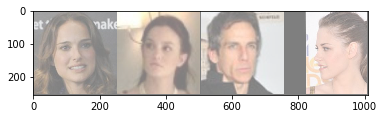

GroundTruth:  Natalie Portman Leighton Meester Ben Stiller Kristen Stewart


In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [21]:
# epsilon = 10**(-15)
# tmp = 1
# while(epsilon > 10**(-25) and tmp > 0):
trainloader, testloader, classes = prepare_data()
device = cuda_init()
net = prepare_and_init_Net(6, 12, 24, 10**(-15))
criterion, optimizer = crit_and_opt(0.001)
tmp = learn(device, trainloader, testloader, optimizer, criterion)
# epsilon *= 10**(-3)

[1,   100] loss: 3.354
[1,   200] loss: 3.162
[1,   300] loss: 3.043
[1,   400] loss: 2.853
[1,   500] loss: 2.849
[1,   600] loss: 2.716
[1,   700] loss: 2.604
[1,   800] loss: 2.527
[1,   900] loss: 2.612
[1,  1000] loss: 2.389
[1,  1100] loss: 2.381
[1,  1200] loss: 2.239
[1,  1300] loss: 2.366
[1,  1400] loss: 2.250
[1,  1500] loss: 2.132
[1,  1600] loss: 2.299
[1,  1700] loss: 2.126
[1,  1800] loss: 2.086
[1,  1900] loss: 2.167
[1,  2000] loss: 2.113
[1,  2100] loss: 2.052
[1,  2200] loss: 1.814
[1,  2300] loss: 1.922
[1,  2400] loss: 1.927
[1,  2500] loss: 2.007
[1,  2600] loss: 1.908
[1,  2700] loss: 1.964
[1,  2800] loss: 1.810
running loss at end of epoch:  2.345393224784306
Accuracy of the network on the 2772 test images: 47.366522 %
[2,   100] loss: 1.724
[2,   200] loss: 1.758
[2,   300] loss: 1.656
[2,   400] loss: 1.545
[2,   500] loss: 1.667
[2,   600] loss: 1.601
[2,   700] loss: 1.656
[2,   800] loss: 1.578
[2,   900] loss: 1.659
[2,  1000] loss: 1.556
[2,  1100] loss:

In [23]:
PATH = './actors_net_batch_norm.pth'
torch.save(net.state_dict(), PATH)

In [27]:
net = prepare_and_init_Net(6, 12, 24, 10**(-15))
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [28]:
class_correct = list(0. for i in range(28))
class_total = list(0. for i in range(28))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(28):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of Natalie Portman : 70 %
Accuracy of Julia Roberts : 58 %
Accuracy of Neil Patrick Harris : 66 %
Accuracy of Keifer Sutherland : 71 %
Accuracy of Ben Stiller : 73 %
Accuracy of Anne Hathaway : 65 %
Accuracy of David Boreanaz : 81 %
Accuracy of Jamie Foxx : 85 %
Accuracy of Sofia Vergara : 77 %
Accuracy of Elizabeth Banks : 68 %
Accuracy of Jensen Ackles : 71 %
Accuracy of Amy Adams : 67 %
Accuracy of Kristen Bell : 67 %
Accuracy of Bradley Cooper : 71 %
Accuracy of Emily Deschanel : 71 %
Accuracy of Zooey Deschanel : 85 %
Accuracy of Jon Hamm : 82 %
Accuracy of Scarlett Johansson : 69 %
Accuracy of Blake Lively : 78 %
Accuracy of Eva Longoria : 72 %
Accuracy of Amy Poehler : 74 %
Accuracy of Kristen Stewart : 69 %
Accuracy of Kerry Washington : 78 %
Accuracy of Leighton Meester : 77 %
Accuracy of Olivia Wilde : 65 %
Accuracy of Zac Efron : 81 %
Accuracy of Miley Cyrus : 76 %
Accuracy of Jim Parsons : 89 %


In [ ]:
torch.set_default_tensor_type(torch.FloatTensor)
import math
device = torch.device("cpu")
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.device)
print(images[0].shape)
print(torch.ones(images.shape[2], 1).shape)

In [ ]:


print(images[3][0])

In [11]:
def tensor_2d_mean(image):
    return torch.mm(torch.mm(image,torch.ones(image.shape[0], 1)).T, torch.ones(image.shape[1], 1)) / (image.shape[0]*image.shape[1])



print(tensor_2d_mean(images[3][0]))

print(images[0][0].mean())

RuntimeError: Expected object of device type cuda but got device type cpu for argument #1 'self' in call to _th_mm

In [18]:
torch.set_default_tensor_type(torch.FloatTensor)
import math
device = torch.device("cpu")
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.device)
print(images[0].shape)
print(torch.ones(images.shape[2], 1).shape)
# print(images.reshape(images.shape[1], images.shape[0], images.shape[2], images.shape[3]))
def mini_batch_normalization(mini_batch, epsilon):
    # print("before mean: ", mini_batch.mean())
    batch_size = mini_batch.shape[0]
    # print(mini_batch.shape)
    # print(batch_size)
    number_of_layers = mini_batch.shape[1]
    sum = torch.zeros(mini_batch.shape[2], mini_batch.shape[3])
    for i in range(number_of_layers):
        # print(i)
        for j in range(batch_size):
            # print("mini batch mean: ", mini_batch[j][i].mean())
            sum = sum + mini_batch[j][i]
            # print("sum mean: ", sum.mean())
        # print(sum.mean())
        mean = tensor_2d_mean(sum) / batch_size
        sum = 0
        # print("Mean: ",mean.mean())
        for j in range(batch_size):
            sum += (mini_batch[j][i] - mean)**2
        variance = tensor_2d_mean(sum) / batch_size
        # print(mean, variance)
        for j in range(batch_size):
            mini_batch[j][i] = (mini_batch[j][i] - mean)  / torch.sqrt(variance + epsilon)
            # print("after mean: ", mini_batch[j][i].mean())
        sum = 0
    return mini_batch
#


# print(images.mean())
print(mini_batch_normalization(images, 10**(-10)).mean())
print(mini_batch_normalization(images, 10**(-20)).var())

cpu
torch.Size([3, 250, 250])
torch.Size([250, 1])
before mean:  tensor(0.3791)
torch.Size([4, 3, 250, 250])
4
0
mini batch mean:  tensor(0.4982)
sum mean:  tensor(0.4982)
mini batch mean:  tensor(0.6025)
sum mean:  tensor(1.1007)
mini batch mean:  tensor(0.3820)
sum mean:  tensor(1.4827)
mini batch mean:  tensor(0.3833)
sum mean:  tensor(1.8660)
tensor(1.8660)
Mean:  tensor(0.4665)
after mean:  tensor(0.1158)
after mean:  tensor(0.4966)
after mean:  tensor(-0.3084)
after mean:  tensor(-0.3040)
1
mini batch mean:  tensor(0.3630)
sum mean:  tensor(0.3630)
mini batch mean:  tensor(0.4845)
sum mean:  tensor(0.8475)
mini batch mean:  tensor(0.2937)
sum mean:  tensor(1.1412)
mini batch mean:  tensor(0.2725)
sum mean:  tensor(1.4137)
tensor(1.4137)
Mean:  tensor(0.3534)
after mean:  tensor(0.0417)
after mean:  tensor(0.5684)
after mean:  tensor(-0.2591)
after mean:  tensor(-0.3510)
2
mini batch mean:  tensor(0.2909)
sum mean:  tensor(0.2909)
mini batch mean:  tensor(0.4281)
sum mean:  tensor